# Seq2Seq 기계 번역

2010년 이후 가장 큰 관심을 받은건 역시 알파고 였지만, 그와 더불어 크게 화제가 된 또다른 머신러닝 모델이 있었습니다.
바로 한 언어를 다른 언어로 해석시켜주는 **뉴럴 기계번역(Neural Machine Translation)** 모델입니다. 
항상 RNN이 기계번역에 쓰였던 것은 아니지만, RNN 기반의 번역모델인 **Sequence to Sequence**(줄여서 Seq2Seq 이라고도 합니다) 모델은 기계번역의 새로운 패러다임을 열었다고 할 정도로 기존 번역모델의 성능을 아득히 뛰어넘었습니다.

이름에서 알 수 있듯이 Seq2Seq 모델은 순차적인 형태의 배열 혹은 문장을 다른 문장으로 바꾸거나 번역해주는 모델입니다.
일반적으로 Seq2Seq와 같은 기계번역 모델이 이러한 능력을 학습하려면 원문과 번역문이 쌍을 이루는 형태의 다량의 텍스트 데이터셋이 필요합니다.
당연히 이런 데이터를 가지고 학습하는 모델들은 고용량 GPU와 복잡한 텍스트 전처리 과정, 그리고 긴 학습시간 등 꽤 많은 리소스를 필요로 합니다.

그래서 이번 프로젝트에선 임의로 Seq2Seq 모델을 아주 간단화 시켰습니다.
한 언어로 된 문장을 다른 언어로 된 문장으로 번역하는 덩치가 큰 모델이 아닌
영어 알파벳 문자열("hello")을 스페인어 알파벳 문자열("hola")로 번역하는 Mini Seq2Seq 모델을 같이 구현해 보겠습니다.

## Seq2Seq 개요

지금까지 이 책을 읽으면서 이미 눈치를 채셨을 수도 있겠지만, 복잡한 일을 처리하는 딥러닝 모델이 단 하나의 신경망으로 이루어진 경우는 매우 드뭅니다.
우리가 앞 프로젝트에서 같이 구현한 비교적 간단한 모델인 감정분석(Sentiment Analysis) 모델도 RNN 과 다층신경망, 이 두 신경망이 연결된 형태였습니다.
이번 프로젝트의 메인 토픽인 Seq2Seq모델 또한 마찬가지입니다. 엄밀히 말하자면 Seq2Seq 모델은 서로 다른 역할을 하는 두개의 RNN을 이어붙인 신경망입니다

두개의 RNN이 연결되어 있다는 점에서 Seq2Seq 모델이 매우 어렵고 복잡하게 느껴지실 수도 있습니다.
하지만 실제 우리가 번역을 할때 거치는 생각과 과정을 곱씹어보면 Seq2Seq가 왜 이런 구조로 구현되었는지 쉽게 이해가 되실겁니다.
일반적으로 우리가 영어와 같은 외국어를 한국어로 번역하는 과정은 다음과 같습니다.
먼저 외국어 문장을 읽고 그 내용을 이해합니다.
그다음 이러한 이해를 바탕으로 한국어 단어들을 하나 하나 문맥에 맞게 써내려갑니다.
이처럼 번역은 원문의 이해와 번역문 작성, 이렇게 크게 두가지 동작을 필요로 합니다.  

Seq2Seq 모델에선 이 두가지 동작을 **인코더(Encoder)** 와 **디코더(Decoder)** 라고 하는 각자 다른 RNN에 부여하므로써 기계번역을 실행합니다.
첫번째 RNN인 **인코더(Encoder)** 는 원문을 입력받고 그 뜻을 학습합니다. 인코더를 통해 학습된 내용을 이어받는 **디코더(Decoder)** 는 원문의 내용을 바탕으로 번역문을 차례대로 출력합니다.

### 인코더

인코더는 원문의 내용을 학습하는 RNN 입니다.  
한 마디로 원문 속의 모든 단어들을 입력받아 문장의 뜻을 내포하는 하나의 고정된 크기의 텐서로 압축시킵니다.
이렇게 압축된 텐서는 원문의 뜻과 내용을 담고 있다고 하여 **Context Vector(내용 벡터)** 라고 부릅니다.

### 디코더

다시 말씀드리지만, 번역을 할 때에는 항상 '원문이 말하는 바가 무엇인가', 그리고 '번역문과 원문이 전하는 뜻이 같은가'라는 생각을 하고 있어야합니다.  
이는 곧 번역문의 단어 하나, 글자 한 자를 작성할 때도 원문이 주는 정보에 입각하여야 한다는 뜻입니다.
즉 디코더가 번역문의 단어나 토큰을 출력할 때 마다 인코더의 Context Vector를 어느 형태로든 전달받아야 합니다.

![rl](./assets/encoder_decoder.png)
 
사실 인코더의 Context Vector 를 디코더에 전해주는데는 여러 방법이 있습니다.
원본 Sequence to Sequence 모델에선 인코더의 Context Vector 가 디코더에 입력되는 모든 번역문 토큰 벡터에 이어붙였습니다. 이렇게 구현함으로써 디코더가 다음 번역문 토큰을 예상할 때 원문의 내용을 고려할 수 있도록 말이죠.
우리가 구현해 볼 Mini Seq2Seq은 이러한 동작은 생략하고 단순히 디코더 RNN 의 첫번쨰 Hidden State 을 인코더의 Context Vector 로 정의함으로써 원문의 내용을 디코더에 입력합니다.  
Context Vector를 입력받은 디코더는 번역문 속의 토큰을 입력받아 번역문 속 다음 토큰을 예상합니다.
디코더가 예상한 토큰과 실제 토큰을 비교하여 오차를 줄여나가는 것이 Seq2Seq 모델이 학습하는 기본원리입니다.  

## Seq2Seq 모델을 구현하고 기계번역을 해 봅시다.

여느때와 마찬가지로 구현에 필요한 라이브러리들을 임포트합니다.

```python
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
```

이번 프로젝트에선 워드 임베딩(Word Embedding)이 아닌 캐릭터 임베딩(Character Embedding)을 사용하겠습니다.
즉 단어가 아닌 알파벳들을 벡터로 표현하여 알파벳의 배열인 단어를 벡터의 배열로 표현하겠습니다.

앞의 프로젝트에서 했던것과 마찬가지로, 임베딩을 하기 위해선 '사전'을 정의해야 합니다. ascii 코드엔 총 256개의 캐릭터가 속해 있으므로, 모든 캐릭터를 사전에 담아내기 위해 vocab_size 를 ascii 코드의 총 갯수인 256으로 정의하겠습니다.

```python
vocab_size = 256  # ascii size
```

Seq2Seq 모델에 입력될 원문과 번역문 ascii 코드의 배열로 정의하고 파이토치 텐서로 바꿔줍니다.

```python
x_ = list(map(ord, "hello"))  # convert to list of ascii codes
y_ = list(map(ord, "hola"))   # convert to list of ascii codes
x = Variable(th.LongTensor(x_))
y = Variable(th.LongTensor(y_))
```

Seq2Seq 모델 클래스를 정의합니다.
전 프로젝트와 마찬가지로 n_layer는 1로 정의해 주고 RNN 의 Hidden Size를 입력받도록 설정합니다.

```python
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
```

임베딩 사이즈를 설정하고 인코더와 디코더를 LSTM 객체로 정의해줍니다.
원래는 원문을 위한 임베딩과 번역문을 위한 임베딩을 따로 정의해 줘야 하지만 간단한 Seq2Seq 모델인 만큼 임베딩을 하나만 정의해 주겠습니다.

```python
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.LSTM(hidden_size, hidden_size)
        self.decoder = nn.LSTM(hidden_size, hidden_size)
```

디코더가 번역문 속 다음 토큰을 예상하기 위해선 다음과 같이 작은 신경망을 하나 더 만들어 줘야합니다.

```python
        self.project = nn.Linear(hidden_size, vocab_size)
```

forward 함수를 구현하면서 위에 정의된 신경망 모듈과 객체들이 어떻게 서로 이어붙여 지는지 알아보겠습니다.

인코더의 첫번째 Hidden State을 정의하고 인코더에 입력되는 원문인 'hello' 속의 모든 캐릭터를 임베딩시킵니다.

```python
def forward(self, inputs, targets):
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
```     

'hello'를 인코더에 입력시켜 encoder_state 이라는 텐서로 압축시킵니다.
원문의 Context Vector인 encoder_state를 디코더의 첫번째 Hidden State 로 설정합니다.
디코더가 번멱문 'hola'의 첫번째 토큰인 'h'를 예상하려면 null character 혹은 문장 시작 토큰(Start of Sentence Tocken)을 첫번째 입력데이터로써 받아야 합니다. 이번 예제에서는 ascii 번호 0을 문장 시작 토큰으로 설정하겠습니다.

```python

        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        decoder_state = encoder_state
        decoder_input = Variable(th.LongTensor([[0]]))
```

디코더의 동작에 필요한 for loop 을 구현합니다.
디코더는 인코더와는 달리 번역문 속의 토큰을 입력받을 때 마다 loss를 계산하는데 쓰일 결과값을 출력해야합니다.
위에 정의한 decoder_input 과 encoder의 Context Vector인 decoder_state을 디코더에 입력합니다.

```python
        outputs = []
        for i in range(targets.size()[0]): 
            decoder_input = self.embedding(decoder_input)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
```

decoder를 통해 나온 결과값은 다시 작은 신경망에 입력됩니다.
이렇게 해서 원문의 내용과 현재의 번역문 토큰을 기반으로 추론해 본 번역문의 다음 토큰을 예상하는 결과값을 구합니다.
이 결과값을 outputs라는 배열 속에 저장해 loss 를 계산할 때 사용하겠습니다.

```python
            # Project to the vocabulary size
            projection = self.project(decoder_output.view(1, -1))  # batch x vocab_size
            
            # Make prediction
            prediction = F.softmax(projection)  # batch x vocab_size
            outputs.append(prediction)
```

마지막으로 디코더에 입력되는 데이터를 번역문의 토큰을 업데이트합니다.

```python
            # update decoder input
            _, top_i = prediction.data.topk(1)  # 1 x 1
            decoder_input = Variable(top_i)

```

번역문의 모든 토큰에 대한 결과값들을 배열이라 할 수 있는 outputs을 리턴합니다.

```python
        outputs = th.stack(outputs).squeeze()
        return outputs
```

이렇게 모델의 구현이 끝났습니다.
이제 vocab_size를 256으로, hidden_size를 16으로 설정해 모델을 생성하고 loss 함수와 optimizer를 정의합니다.

```python
seq2seq = Seq2Seq(vocab_size, 16)
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(seq2seq.parameters(), lr=1e-3)
```

1000번의 epoch에 걸쳐 모델을 학습시킵니다.

```python
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data[0]
    log.append(loss_val)
    if i % 100 == 0:
        print("%d loss: %s" % (i, loss_val))
        _, top1 = prediction.data.topk(1, 1)
        for c in top1.squeeze().numpy().tolist():
            print(chr(c), end=" ")
        print()
```

matplotlib 라이브러리를 이용해서 loss 가 줄어드는 것을 한 눈에 확인하실 수 있습니다.

```python
import matplotlib.pyplot as plt
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()
```


### 전체 코드


In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [2]:
vocab_size = 256  # ascii size
x_ = list(map(ord, "hello"))  # convert to list of ascii codes
y_ = list(map(ord, "hola"))   # convert to list of ascii codes
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = Variable(th.LongTensor(x_))
y = Variable(th.LongTensor(y_))

In [4]:
print(x)

tensor([ 104,  101,  108,  108,  111])


In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # Encoder inputs and states
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # Encoder
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # Decoder inputs and states
        decoder_state = encoder_state
        decoder_input = Variable(th.LongTensor([[0]]))
        
        # Decoder
        outputs = []
        for i in range(targets.size()[0]): 
            decoder_input = self.embedding(decoder_input)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            
            # Project to the vocabulary size
            projection = self.project(decoder_output.view(1, -1))  # batch x vocab_size
            
            # Make prediction
            prediction = F.softmax(projection)  # batch x vocab_size
            outputs.append(prediction)
            
            # update decoder input
            _, top_i = prediction.data.topk(1)  # 1 x 1
            decoder_input = Variable(top_i)

        outputs = th.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return Variable(weight.new(self.n_layers, batch_size, self.hidden_size).zero_())

In [6]:
seq2seq = Seq2Seq(vocab_size, 16)
print(seq2seq)
pred = seq2seq(x, y)
print(pred)

Seq2Seq(
  (embedding): Embedding(256, 16)
  (encoder): GRU(16, 16)
  (decoder): GRU(16, 16)
  (project): Linear(in_features=16, out_features=256, bias=True)
)
tensor(1.00000e-03 *
       [[ 4.2006,  3.7457,  2.2790,  ...,  3.9582,  2.9775,  4.4266],
        [ 4.0751,  4.3392,  2.4098,  ...,  5.1254,  3.0554,  4.4903],
        [ 4.4139,  3.9804,  2.0727,  ...,  4.6336,  2.4755,  5.7719],
        [ 3.4358,  2.9780,  2.1254,  ...,  4.3240,  2.6141,  6.2712]])


/Users/sangjunyum/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [8]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data[0]
    log.append(loss_val)
    if i % 100 == 0:
        print("%d loss: %s" % (i, loss_val))
        _, top1 = prediction.data.topk(1, 1)
        for c in top1.squeeze().numpy().tolist():
            print(chr(c), end=" ")
        print()

/Users/sangjunyum/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/sangjunyum/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0 loss: tensor(5.5448)
D æ e  
100 loss: tensor(5.3310)
h o o o 
200 loss: tensor(5.0135)
h o a a 
300 loss: tensor(4.8968)
h o a a 
400 loss: tensor(4.6987)
h o l a 
500 loss: tensor(4.6120)
h o l a 
600 loss: tensor(4.5880)
h o l a 
700 loss: tensor(4.5772)
h o l a 
800 loss: tensor(4.5710)
h o l a 
900 loss: tensor(4.5669)
h o l a 


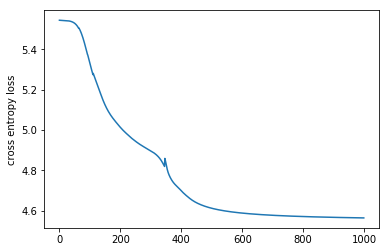

In [9]:
import matplotlib.pyplot as plt
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()